# MODFLOW-USG: Discontinuous water table configuration over a stairway impervious base

One of the most challenging numerical cases for MODFLOW arises from drying-rewetting problems often associated with abrupt changes in the elevations of impervious base of a thin unconfined aquifer. This problem simulates a discontinuous water table configuration over a stairway impervious base and flow between constant-head boundaries in column 1 and 200. This problem is based on 

[Zaidel, J. (2013), Discontinuous Steady-State Analytical Solutions of the Boussinesq Equation and Their Numerical Representation by Modflow. Groundwater, 51: 952–959. doi: 10.1111/gwat.12019](https://doi.org/10.1111/gwat.12019)

The model consistes of a grid of 200 columns, 1 row, and 1 layer; a bottom altitude of ranging from 20 to 0 m; constant heads of 23 and 5 m in column 1 and 200, respectively; and a horizontal hydraulic conductivity of $1x10^{-4}$ m/d.  The discretization is 5 m in the row direction for all cells.

In this example results from MODFLOW-USG will be evaluated.

In [1]:
import sys
from pathlib import Path
from tempfile import TemporaryDirectory

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

proj_root = Path.cwd().parent.parent

# run installed version of flopy or add local path
try:
    import flopy
except:
    sys.path.append(proj_root)
    import flopy

print(sys.version)
print("numpy version: {}".format(np.__version__))
print("matplotlib version: {}".format(mpl.__version__))
print("flopy version: {}".format(flopy.__version__))

3.11.0 | packaged by conda-forge | (main, Jan 15 2023, 05:44:48) [Clang 14.0.6 ]
numpy version: 1.24.2
matplotlib version: 3.6.3
flopy version: 3.3.7


In [2]:
# Set temporary workspace and MODFLOW executable
# (assume executable is in users' path variable)
mfexe = "mfusg"
modelname = "zaidel"
temp_dir = TemporaryDirectory()
workspace = Path(temp_dir.name) / modelname
workspace.mkdir()

## Model parameters

In [3]:
# model dimensions
nlay, nrow, ncol = 1, 1, 200
delr = 50.0
delc = 1.0

# boundary heads
h1 = 23.0
h2 = 5.0

# cell centroid locations
x = np.arange(0.0, float(ncol) * delr, delr) + delr / 2.0

# ibound
ibound = np.ones((nlay, nrow, ncol), dtype=int)
ibound[:, :, 0] = -1
ibound[:, :, -1] = -1

# bottom of the model
botm = 25 * np.ones((nlay + 1, nrow, ncol), dtype=float)
base = 20.0
for j in range(ncol):
    botm[1, :, j] = base
    # if j > 0 and j % 40 == 0:
    if j + 1 in [40, 80, 120, 160]:
        base -= 5

# starting heads
strt = h1 * np.ones((nlay, nrow, ncol), dtype=float)
strt[:, :, -1] = h2

## Create and run the MODFLOW-USG model

In [4]:
# make the flopy model
mf = flopy.mfusg.MfUsg(modelname=modelname, exe_name=mfexe, model_ws=workspace)
dis = flopy.modflow.ModflowDis(
    mf,
    nlay,
    nrow,
    ncol,
    delr=delr,
    delc=delc,
    top=botm[0, :, :],
    botm=botm[1:, :, :],
    perlen=1,
    nstp=1,
    steady=True,
)
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
lpf = flopy.mfusg.MfUsgLpf(mf, hk=0.0001, laytyp=4)
oc = flopy.modflow.ModflowOc(
    mf,
    stress_period_data={
        (0, 0): ["print budget", "print head", "save head", "save budget"]
    },
)
sms = flopy.mfusg.MfUsgSms(
    mf,
    nonlinmeth=1,
    linmeth=1,
    numtrack=50,
    btol=1.1,
    breduc=0.70,
    reslim=0.0,
    theta=0.85,
    akappa=0.0001,
    gamma=0.0,
    amomentum=0.1,
    iacl=2,
    norder=0,
    level=5,
    north=7,
    iredsys=0,
    rrctol=0.0,
    idroptol=1,
    epsrn=1.0e-5,
    mxiter=500,
    hclose=1.0e-3,
    hiclose=1.0e-3,
    iter1=50,
)
mf.write_input()

# remove any existing head files
try:
    (workspace / f"{modelname}.hds").unlink(missing_ok=True)
except:
    pass

# run the model
success, buff = mf.run_model(silent=True, report=True)
assert success, "Failed to run"
for line in buff:
    print(line)


                                  MODFLOW-USG      
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER FLOW MODEL
                             Version 1.5.00 02/27/2019                       

 Using NAME file: zaidel.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/05/01 21:54:58

 Solving:  Stress period:     1    Time step:     1    Groundwater Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/05/01 21:54:58
 Elapsed run time:  0.010 Seconds

  Normal termination of simulation


### Read the simulated MODFLOW-USG model results

In [5]:
# Create the mfusg headfile object
headfile = workspace / f"{modelname}.hds"
headobj = flopy.utils.HeadFile(headfile)
times = headobj.get_times()
mfusghead = headobj.get_data(totim=times[-1])

### Plot MODFLOW-USG results

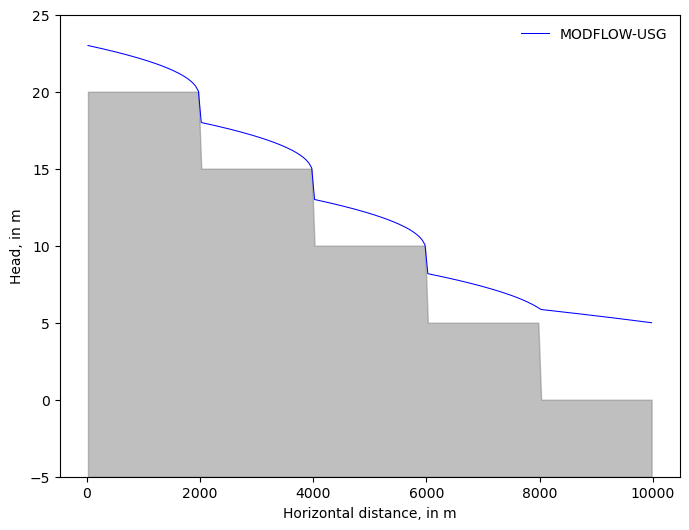

In [6]:
fig = plt.figure(figsize=(8, 6))
fig.subplots_adjust(
    left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=0.25
)
ax = fig.add_subplot(1, 1, 1)
ax.plot(
    x, mfusghead[0, 0, :], linewidth=0.75, color="blue", label="MODFLOW-USG"
)
ax.fill_between(x, y1=botm[1, 0, :], y2=-5, color="0.5", alpha=0.5)
leg = ax.legend(loc="upper right")
leg.draw_frame(False)
ax.set_xlabel("Horizontal distance, in m")
ax.set_ylabel("Head, in m")
ax.set_ylim(-5, 25);

In [7]:
try:
    # ignore PermissionError on Windows
    temp_dir.cleanup()
except:
    pass